In [7]:
import numpy as np
import keras


In [8]:
### 自定义dataset使用说明
'''我们这个接口主要是面对图像文件的实现按batch输入。需要在data中的格式是:

data/dataset1/
        train/
            img_1.jpg(.png...)
            img_2.jpg
            ....
            img_N.jpg
        train_label.json        
            {img_1.jpg : label1, 
             img_2.jpg : label2,
             ...
             img_3.jpg : label_3,
             ...
        valid/
            img_1.jpg(.png...)
            img_2.jpg
            ....
            img_N.jpg
        valid_label.json
输入到Dataset的label需要是一个关于文件名的label字典
'''


'我们这个接口主要是面对图像文件的实现按batch输入。需要在data中的格式是:\n\ndata/dataset1/\n        train/\n            img_1.jpg(.png...)\n            img_2.jpg\n            ....\n            img_N.jpg\n        train_label.json        \n            {img_1.jpg : label1, \n             img_2.jpg : label2,\n             ...\n             img_3.jpg : label_3,\n             ...\n        valid/\n            img_1.jpg(.png...)\n            img_2.jpg\n            ....\n            img_N.jpg\n        valid_label.json\n输入到Dataset的label需要是一个关于文件名的label字典\n'

In [49]:
from PIL import Image
import os 
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataset_dir,list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 characters='', shuffle=True,maxLabelLength=10):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.characters = characters
        self.n_classes = len(self.characters)
        self.shuffle = shuffle
        self.on_epoch_end()
        self.dataset_dir = dataset_dir
        self.maxLabelLength = maxLabelLength

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, *self.dim, self.n_channels), dtype=np.float)
        Y = np.zeros([self.batch_size, self.maxLabelLength],dtype=int) 
        input_length = np.zeros([self.batch_size, 1])
        label_length = np.zeros([self.batch_size, 1])
        
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = Image.open(os.path.join(self.dataset_dir, ID)).convert('L')
            img = img.resize((self.dim[1],self.dim[0]))
            img = np.array(img, 'f') / 255.0 - 0.5
            X[i,] = np.expand_dims(img, axis=2)
            
            label_origin = self.labels[ID]
            label = self.__one_hot(label_origin,length=len(label_origin))
            label_length[i] = len(label)

            if(len(label) <= 0):
                print("%s label len < 0" %ID)
            # the input length for ctc_loss, for densenet pool size is about 8
            input_length[i] = self.dim[0] // 8
            Y[i, :len(label)] = label
    
            label_length[i] = len(label)
            
        inputs = {'the_input': X,
            'the_labels': Y,
            'input_length': input_length,
            'label_length': label_length,
            }
        outputs = {'ctc': np.zeros([self.batch_size])}
        return inputs, outputs

    def __one_hot(self, text,length):
        label = np.zeros(length)
        for i, char in enumerate(text):
            index = self.characters.find(char)
            if index == -1:
                index = self.characters.find(u' ')
            if i < length:
                label[i] = index
        return label



In [50]:
import json
save_dir = './images/num_dataset_v1/'
with open(save_dir+"/train_label.json",'r',encoding='utf-8') as json_file:
    label_dict=json.load(json_file)
# list_id = list(label_dict.keys())
# print(list_id[:10])

In [51]:
import sys
import imp
sys.path.insert(0,'/mnt/wuwenhui/git_ocr_project/chinese_ocr_densenet/densenet/')
import keys
list_id = list(label_dict.keys())
charaters = keys.alphabet[:]
train_gen = DataGenerator(dataset_dir='./images/num_dataset_v1/train/',list_IDs=list_id,
                          batch_size=16, dim=(32,280),labels=label_dict,characters=charaters,
                          maxLabelLength=15)

(32, 280, 1) [118  22  71   6 389   0   0   0   0   0   0   0   0   0   0]


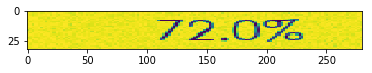

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline
item_test = ''
# for item in train_gen:
# #     print(item)
#     item_test = item
iterator = iter(train_gen)
item = iterator.__next__()
X,y = item
i = np.random.randint(0,X['the_labels'].shape[0])
train_gen.on_epoch_end()
i =0
print(X['the_input'][i].shape,X['the_labels'][i])
image = np.squeeze(X['the_input'][i])
plt.imshow(image)


In [75]:
iterator = iter(train_gen)
item = iterator.__next__()